# Classification combining handcrafted and convolutional features
In this notebook, it is presented a supervised classification using support vector machine (SVM). It combines handcrafted texture with convolutional features (presented in the previous notebook: feats-CC-hand-conv) 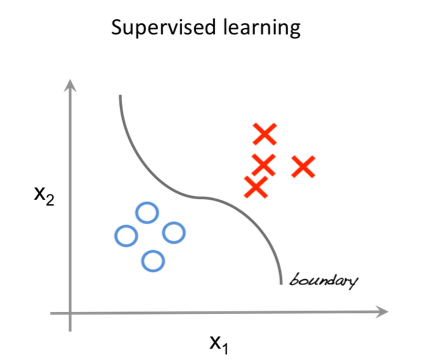

The goal is to introduce:
- grid search technique: automatically find optimum parameters (exhaustively considers all parameter combinations)
- cross-validation: split training and testing sets 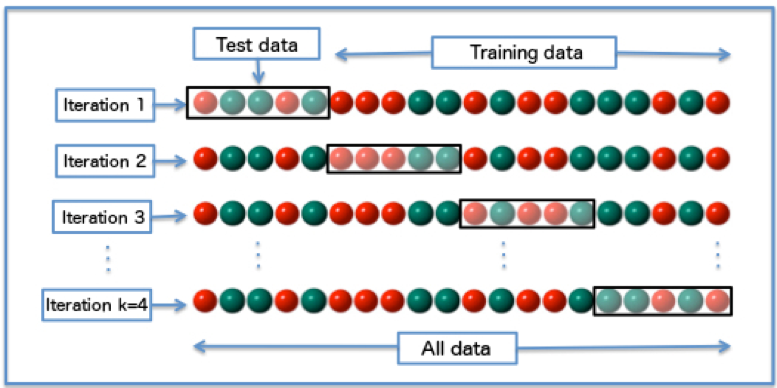
- feature space visualization: top-two components computed through the principal component analysis algoritmn
- quantitative analysis of achieved results through the confusion matrix

Observation: All experiments performed with 100 samples to limite the processing time

In [6]:
## Confusion matrix and visualization of feature space functions ##

%matplotlib inline
import matplotlib.pylab as plt
import os
import numpy as np
from sklearn.svm import SVC
from sklearn import decomposition
from sklearn.model_selection import KFold
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,size=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, size=14, rotation=45)
    plt.yticks(tick_marks, classes, size=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", size=20,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',size=16)
    plt.xlabel('Predicted label',size=16)
    
def viz_feature_space(X,y,lab):
    """
    This function plots a 2D visualization of the feature space.
    """
    sym = ['*','o']
    plt.figure(facecolor = 'w')
    pca = decomposition.PCA(n_components=2)
    X_viz = pca.fit_transform(X)
    
    for i in np.unique(y):
        inplot, = plt.plot(X_viz[y==i,0],X_viz[y==i,1],sym[int(i)],label=lab[int(i)])
    plt.ylabel('pca2',size=16),plt.xlabel('pca1',size=16)#,plt.title('visualize feature space',size=20)
    plt.legend()
    plt.show()

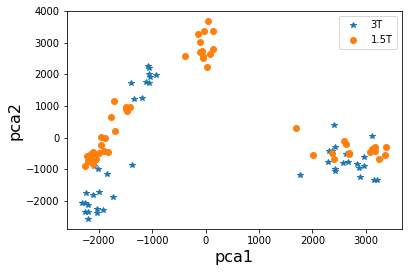

In [3]:
### Feature's space: 2 classification problem (distinguish 3T from 1.5T images)###
import numpy as np
import os
nsamples = 100

data = np.load(os.path.join('../Data/'+"feats_cc359.npy"))

## extract information (feats and labels) from data 
np.random.seed(0)
np.random.shuffle(data) # randomize samples

y = (data[:nsamples,1]>3).astype(np.uint8) # create label vector by using data information (0 - 3T; 1 - 1.5T)
lab=['3T','1.5T']
X = data[:nsamples,4:] # extract feats from data (only removing other image/patients infos)

## Possible 2D visualization of the feature space by reducing it by using principal component analysis
viz_feature_space(X,y,lab)

In [4]:
### SVM - grid-search; cross-validation  ###
## Parameter for Grid-Search
tuned_parameters = [
    {'C': [1, 100], 'kernel': ['linear']},
    #{'C': [1, 100], 'gamma': [0.1, 0.01], 'kernel': ['rbf']},
    ]

## Cross validation using 2-fold ##
kf = KFold(n_splits=2)
final_cm = np.zeros((2,2))
acc = []
for train, test in kf.split(X,y):
    X_train = X[train]
    y_train = y[train]
    X_test = X[test]
    y_test = y[test]
    clf = GridSearchCV(SVC(), tuned_parameters,scoring='accuracy') # grid search maximizing the accuracy
    clf.fit(X_train, y_train) # training
    y_pred = clf.predict(X_test) # testing
    acc.append(accuracy_score(y_test, y_pred))
    final_cm +=confusion_matrix(y_test, y_pred)

print 'accuracy within cross-validation:',acc # two accuracy achieved in each iteration of 2-fold

accuracy within cross-validation: [1.0, 0.97999999999999998]


final accuracy: 0.99


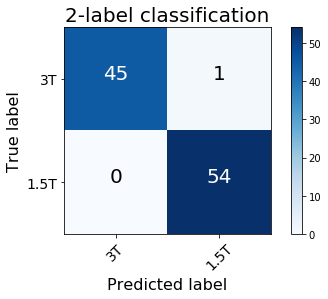

In [7]:
### Quantitative analysis of achieved results ###
print 'final accuracy:',np.array(acc).mean() # final accuracy is the mean value of the accuracy array

## confusion matrix: possible to compute accuracy, sensitivity and specificity
plt.figure(facecolor = 'w')
plot_confusion_matrix((final_cm).astype(int), classes=lab,
                      title='2-label classification')
plt.show()

## Questions:
1. Now classify samples based on patients gender (female-10 or male-11), instead of using magnetic field. This information is stored at data[:nsamples,3]